<a href="https://colab.research.google.com/github/boriskuchin/MADMO-BASE-2024/blob/main/09_linear_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Линейная классификация

# Recap. Линейная регрессия

- **Данные** - $X = \{x_i, y_i\}_{i=1}^N$, где $x_i=(x_i^{(1)}, ..., x_i^{(k)})$, $y_i \in \mathbb{R} \quad \forall i$.


- **Модель** - $f_{\theta}: \hat{y}_i=w_0 + \sum_{j=1}^k w_j x_i^{(j)}$


- **Обучение** - $θ^* = \arg \min\limits_\theta \frac{1}{N} \sum_{i=1}^N L(y_i, \hat{y}_i), \quad L(y_i, \hat{y}_i) = (y_i - \hat{y}_i)^2$

# Recap. Задача классификации

А что с задачей классификации? Рассмотрим сначала простую версию - бинарная классификация - $y_i \in \{0, 1\}$ (или $y_i \in \{-1, 1\}$) $\quad \forall i \in [1, N]$.

![](https://yastatic.net/s3/ml-handbook/admin/1_10_22eb9c5128.png)

Простыми словами - хотим найти плоскость в $K$-мерном пространсве признаков, которая лучше всего отделяет объекты разных классов друг от друга.

Будем рассматривать упрощенную задачу - когда такая плоскость, которая безошибочно разделяет объекты, существует.

# Проблемы линейной регрессии для классификации

В регрессии - $y_i \in \mathbb{R}$, в классификации - $\{0,1\}$ или $\{-1, +1\}$. Как быть?

# Линейная регрессия "в лоб"

Вообще нас ничего не останавливает от того, чтобы предсказывать в рамках задачи регрессии метки классов - например, $\{-1, +1\}$, и минимизируя MSE, а затем предсказывать метку как $sign(\hat{y}_i)$:

На практике - это неэффективно:

- малый штраф за ошибки на объектах, которые лежат близко к *разделяющей плоскости*, но не с той стороны
- ошибкой будет считаться предсказание, например, 5 вместо 1, хотя нам-то на самом деле не важно, какой у числа модуль, лишь бы знак был правильным

In [ ]:
import numpy as np
from matplotlib import pyplot as plt
from sklearn.datasets import make_classification
from sklearn.linear_model import LinearRegression

In [ ]:
X, y = make_classification(
    n_features=1,
    n_informative=1,
    n_redundant=0,
    n_repeated=0,
    n_clusters_per_class=1,
    shift=2.0,
    scale=0.4,
    random_state=412
)
X, y = X ** 4 + 0.3, y.astype(float)

linreg = LinearRegression()
linreg.fit(X, y)

LinearRegression()

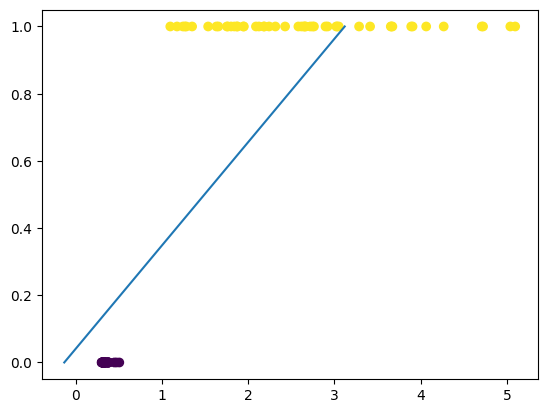

In [ ]:
plt.scatter(X.T, y, c=y)

line_y = np.array([0, 1])
line_x = (line_y - linreg.intercept_) / linreg.coef_
plt.plot(line_x, line_y)
plt.show()

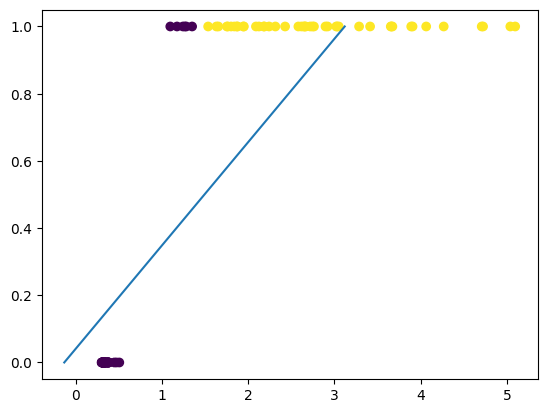

In [ ]:
y_hat = (linreg.coef_ * X + linreg.intercept_)[:, 0]
y_hat = (y_hat > 0.5).astype(int)
plt.scatter(X.T, y, c=y_hat)

line_y = np.array([0, 1])
line_x = (line_y - linreg.intercept_) / linreg.coef_
plt.plot(line_x, line_y)
plt.show()

# Функция зазора

Раз MSE не подходит, будем конструировать новую функцию потерь. Раз мы хотим минимизировать ошибку, то давайте так и сделаем:

$$\sum_{i=1}^N \mathbb{I}[y_i \neq sign \langle w\cdot x_i \rangle] \to \min$$

Домножим на $y_i$ и получим:

$$ \sum_{i=1}^N \mathbb{I}[y_i \langle w\cdot x_i \rangle < 0] \to \min $$

Величина $M = y_i \langle w\cdot x_i \rangle$ называется отступом (*margin*) классификатора. Такая фунция потерь называется *misclassification loss*.

У этой функции потерь есть ряд полезных свойств:

- $M>0$, когда $sign(y_i) = sign(\langle w\cdot x_i \rangle)$, а $M<0$, когда $sign(y_i) \neq sign(\langle w\cdot x_i \rangle)$
- чем больше отступ, тем больше расстояние от $x_i$ до разделяющей гиперплоскости, то есть "уверенность классификатора" и наоборот



От каждого из отступов мы вычисляем функцию $F$:

$$F(M) = \mathbb{I}[M < 0] = \begin{cases}
1, \quad M < 0 \\
0, \quad M > 0
\end{cases}$$

Хотим минимизировать сумму значений функции $F$ для всех объектов.

Но есть проблема - эта функция является кусочно постоянной, не можем оптимизировать градиентными методами (почему?). Как быть?

Есть выход! Можем подобрать функцию от $M$, которая:
- является гладкой
- для всех значений $M$ эта функция не меньше $F$

# Ошибка персептрона

Немного улучшим функцию $\mathbb{I}[M < 0]$ - будем учитывать отступы не постоянно, но линейно, пропорционально размеру отступа:

$$ F(M) = \max(0, -M) $$

Тогда функция потерь с $L_2$-регуляризацией:

$$ L = \lambda ||w||_2^2 + \sum_i \max(0, -y_i\langle w\cdot x_i \rangle) $$

Найдем градиент:

$$ \nabla_wL = 2\lambda w + \sum_i \begin{cases}
0, \quad y_i\langle w\cdot x_i \rangle > 0 \\
- y_i x_i, \quad y_i\langle w\cdot x_i \rangle < 0
\end{cases} $$

Имеем аналитическую формулу градиента - можем решить задачу с помощью градиентного спуска!

Эта функция потерь впервые была предложена для **перцептрона Розенблатта**, первой вычислительной модели нейросети, которая в итоге привела к появлению глубокого обучения.

Это решение в целом работает, но имеет недостаток - её решение не единственно и сильно зависит от начальных параметров.

Например, все изображённые ниже классификаторы имеют одинаковый нулевой лосс:

![](https://yastatic.net/s3/ml-handbook/admin/1_13_ef3e9fca2c.png)

# Hinge loss. SVM

Надо решить проблему, показанную на картинке выше - разделительные плоскости, которые идеально разделяют обучающую выборку, не должны быть всегда равнозначны.

Простая идея - давайте максимизировать минимальное значение отступа в обучающей выборке:

![](https://yastatic.net/s3/ml-handbook/admin/1_14_34f6185216.png)

Можем это сделать, немного изменив функцию $F$:

$$ F(M) = \max(0, 1-M) $$

$$ L = \lambda ||w||_2^2 + \sum_i \max(0, 1-y_i\langle w\cdot x_i \rangle) $$

$$ \nabla_wL = 2\lambda w + \sum_i \begin{cases}
0, \quad 1 - y_i\langle w\cdot x_i \rangle < 0 \\
- y_i x_i, \quad 1 - y_i\langle w\cdot x_i \rangle > 0
\end{cases} $$

>Но подождите! Мы же всего лишь добавили единичку, почему от нее может что-то принципиально поменяться?

**Интуитивно** - объекты, которые проклассифицированы правильно, но не очень "уверенно" (то есть $0 < M < 1$), продолжают вносить свой вклад в градиент и пытаются "отодвинуть" от себя разделяющую плоскость как можно дальше.

**Более строго**

Отнормируем веса $w$ так, чтобы ближайшие точки к разделительной плоскости, имели отступ $\pm 1$:

$$\exists x_+: \quad \langle x_+, w\rangle = +1$$
$$\exists x_-: \quad \langle x_-, w\rangle = -1$$

Ширина разделяющей полосы выражается формулой (из аналитической геометрии - см. расстояние от точки до плоскости):

$$\frac{\langle x_+ - x_-, w\rangle}{||w||} = \frac{2}{||w||}$$

Но это все счастье возможно лишь тогда, когда $\forall i \quad M_i \geq 1$, или же $\forall i \quad 1 - M_i \leq 0$. Иными словами, можем штрафовать на величину $\max(0, 1 - M_i)$, ч.т.д.

![](https://yastatic.net/s3/ml-handbook/admin/1_15_583bd074b0.png)

**Важные моменты:**

1. Обратим внимание на $\frac{2}{||w||}$ - это ширина разделяющей полосы, ее хотим максимизировать. Это эквивалентно минимизации $||w||$ - получили регуляризацию :)

2. Заметим, что для нашей функции потерь $F = \max(0, 1-M)$ в градиент дают вклад только те объекты, которые имеют отступ $M<1$ - это либо слабо отдаленные от разделяющей плоскости, либо неправильно классифицированы. Остальные объекты (корректно классифицированные и отдаленные от разделяющей плоскости) - не вносят вклад в поиск параметров разделяющей плоскости.

    Объекты-**векторы**, которые вносят вклад в функцию потерь, являются для него **опорными**. В итоге получили **метод опорных векторов** (**SVM**)!

![](https://yastatic.net/s3/ml-handbook/admin/1_12_7fddcb49c6.png)

Для нашего набора данных получим следующее:

In [ ]:
from sklearn.svm import LinearSVC

svc = LinearSVC(C=1.0)
svc.fit(X, y)

LinearSVC()

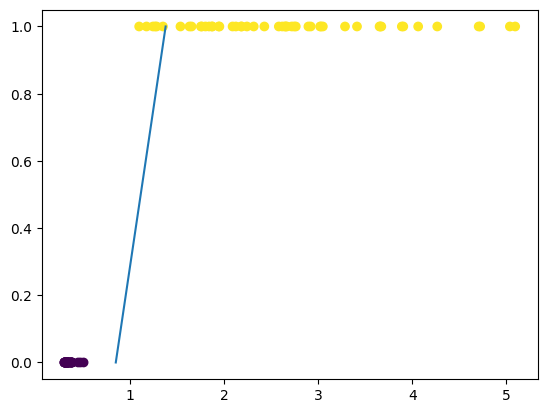

In [ ]:
y_hat = svc.predict(X)
plt.scatter(X.T, y, c=y_hat)

line_y = np.array([0, 1])
line_x = ((line_y - svc.intercept_) / svc.coef_)[0]
plt.plot(line_x, line_y)
plt.show()

## Нелинейные ядра

Иногда линейных признаков не хватает для качественного разделения объектов. Как можно встроить нелинейности в SVM? Для этого используют kernel trick!

Давайте заменим скалярное произведение на новую нелинейную функцию (удовлетворяющую аксиоматике), а остальное оставим как есть!

Часто используемые ядра:
- $K(x_i, x_j) = (x_i \cdot x_j + 1)^p$ - полиномиальное
- $K(x_i, x_j) = e^{\frac{1}{2\sigma^2}(x_i - x_j)^2}$ - гауссово
- $K(x_i, x_j) = e^{-\gamma(x_i - x_j)^2}$ - Radial Basis Function (RBF)
- $K(x_i, x_j) = \tanh{(\eta x_i \cdot x_j + \nu)}$ - сигмоида


Пример:

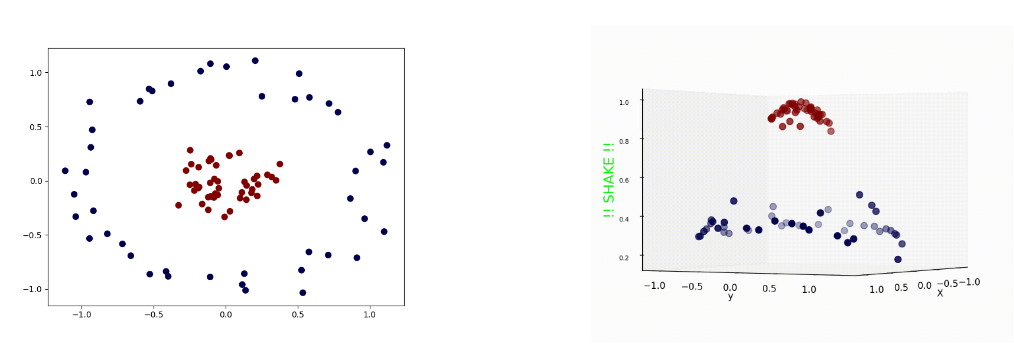

# Логистическая регрессия

До текущего момента мы рассматривали $y_i$ как элементы множества $\{0, 1\}$. Но нам не всегда хотелось бы просто знать предсказание модели - хотелось бы знать и вероятность полученного предсказания. Для бинарной классификации можем представить $y_i \in [0;1]$ - вероятность принадлежности классу "1".

В этом переходе мы усложнили себе жизнь - предсказывать лишь диапазон $[0;1]$ вместо $\mathbb{R}$ не так же просто, как лишь два значения. Как быть в таком случае?

Снова поменять предсказываемое значение - будем предсказывать не вероятность $p$, а **логит** - $\log(\frac{p}{1-p})$. Логит принимает значения из $\mathbb{R}$ - это нам и нужно!

Тогда наша модель примет вид:

$$ \langle w, x_i \rangle = \log \frac{p}{1-p}$$
$$ e^{\langle w, x_i \rangle} = \frac{p}{1-p}$$
$$ p = \frac{1}{1 + e^{-\langle w, x_i \rangle}} $$

Функция $f(x) = \frac{1}{1+e^{-x}}$ называется **сигмоидой**.

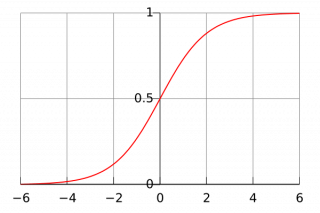

Остается вопрос - какая функция потерь теперь нам подойдет? Здесь нам поможет **метод максимума правдоподобия**!

## Метод максимума правдоподобия

**Метод максимального правдоподобия** (ММП, MLE — англ. **m**aximum **l**ikelihood **e**stimation) в математической статистике — это метод оценивания неизвестного параметра путём максимизации функции правдоподобия. Основан на предположении о том, что вся информация о статистической выборке содержится в **функции правдоподобия**.

**Функция правдоподобия** (или просто правдоподобие) — это функция **совместного** распределения выборки из **параметрического** распределения, рассматриваемое как **функция параметра**.

**Простыми словами** - правдоподобие позволяет понять, насколько вероятно получить данные значения таргета $y$ при данных $X$ и весах $w$.

Для нашей задачи это функция вида:

$$ p(y|X,w) = \prod_{i=1}^N p(y_i| x_i, w) $$

Т.к. решаем задачу бинарной классификации - с двумя дискретными исходами, то имеем два случая $y=1$ и $y=0$, т.е. все произведения можно разбить на две группы:

- для $y=1$ - $p(1|x_i, w) = p(x_i)$
- для $y=0$ - $p(0|x_i, w) = 1-p(x_i)$

Эту систему можно записать следующим образом:

$$ p(y|X,w) = \prod_{i=1}^N p(y_i| x_i, w) = \prod_{i=1}^N p(x_i)^{y_i} \cdot (1-p(x_i))^{1-y_i}$$

Чтобы найти максимум функции правдоподобия, нужно найти производную, а для такого произведения это больно. Как быть?

Можем преобразовать эту функцию с помощью гладкой возрастающей функции и брать уже ее производную! На эту задачу подойдет логарифм:

$$\log p(y|X,w) = \log \prod_{i=1}^N p(x_i)^{y_i} \cdot (1-p(x_i))^{1-y_i} = \sum_{i=1}^N \log p(x_i)^{y_i} \cdot (1-p(x_i))^{1-y_i} = \sum_{i=1}^N \big( y_i\cdot \log p(x_i) + (1-y_i)\cdot \log(1-p(x_i) \big) $$

Так мы записали функцию, которую хотим максимизировать, а функцию потерь мы обычно минимизируем, поэтому домножим на -1, дополнительно отнормируем на кол-во объектов получим новую функцию потерь (Log Loss, Cross Entropy):

$$ L = - \frac{1}{N}\sum_{i=1}^N \big( y_i\cdot \log p(x_i) + (1-y_i)\cdot \log(1-p(x_i) \big) $$

Производная такой функции потерь будет:

$$\nabla L_w = - \frac{1}{N}\sum_{i=1}^N x_i (y_i - p(\langle w, x_i\rangle))$$

Важные моменты:

- несмотря на то, что мы решаем задачу классификации называется **логистической регрессией**, т.к. по сути мы решаем задачу регрессии над логитами
- если мы перейдем к классам -1 и 1, то функция потерь примет вид

$$\frac{1}{N}\sum_{i=1}^N \log(1+e^{-y_i \langle w, x_i \rangle}) = \frac{1}{N}\sum_{i=1}^N \log(1+e^{-M_i})$$


In [ ]:
from sklearn.linear_model import LogisticRegression

logreg = LogisticRegression(C=10.0)
logreg.fit(X, y)

LogisticRegression(C=10.0)

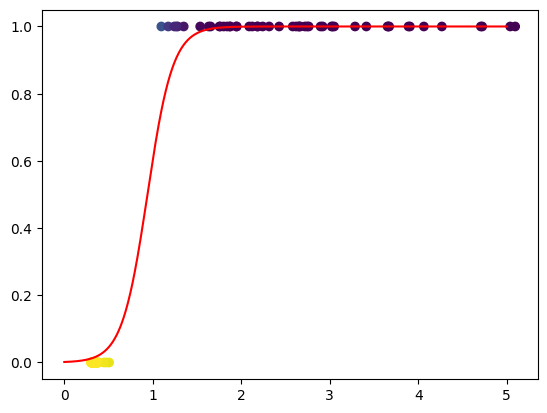

In [ ]:
proba = logreg.predict_proba(X)[:, 0]
plt.scatter(X.T, y, c=proba)

x_arr = np.linspace(0,5,1000)
y_arr = 1 / (1 + np.exp(-logreg.coef_[0] * x_arr - logreg.intercept_))
plt.plot(x_arr, y_arr, c="red")
plt.show()

Так же, как и для линейной регрессии, можем использовать регуляризацию:

$$\hat{w} = \arg\min\limits_{w} (L(x, y, w) + \lambda |w|^2) = \arg\min\limits_{w} (\frac{1}{N} \sum_{i=0}^N \log(1+e^{-y_i w^Tx_i}) + \lambda |w|^2)$$

Так же можем использовать и полиномы разных степеней - тогда в исходном пространстве признаков получим нелинейную разделяющую плоскость.

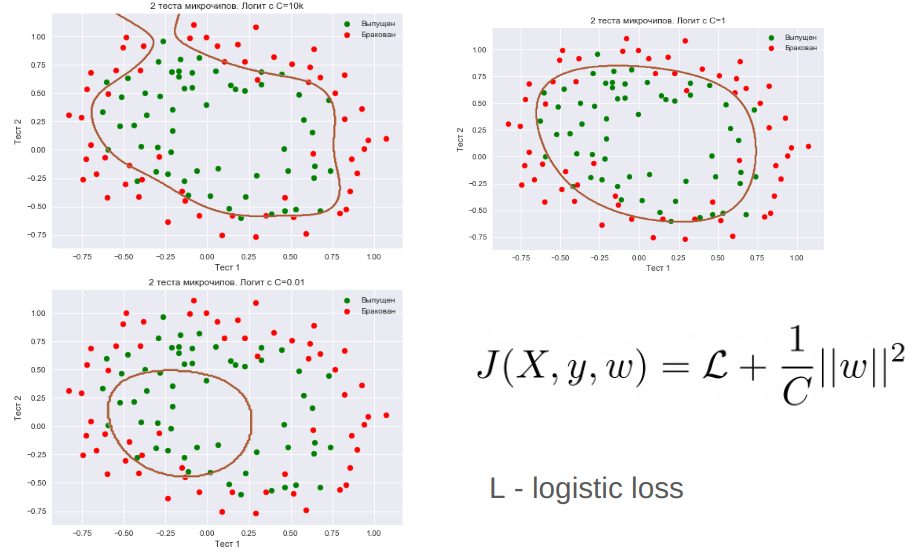

# Многоклассовая классификация

При произвольном количестве классов классификатор приобретает вид:

$$a_w(x) = \arg\max\limits_{y \in Y} (w_y \cdot x)$$

Вероятность считается с помощью функции softmax:

$$ P(y|x, w) = \frac{exp(w_y\cdot x)}{\sum_{z \in Y} exp(w_z\cdot x)} $$

# Практика

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_classification
import seaborn as sns

## Сигмоидальная активация

In [ ]:
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

x: [-6.         -5.87878788 -5.75757576 -5.63636364 -5.51515152]
y: [0.00247262 0.00279037 0.00314881 0.00355314 0.00400918]


Text(0, 0.5, 'sigmoid(x)')

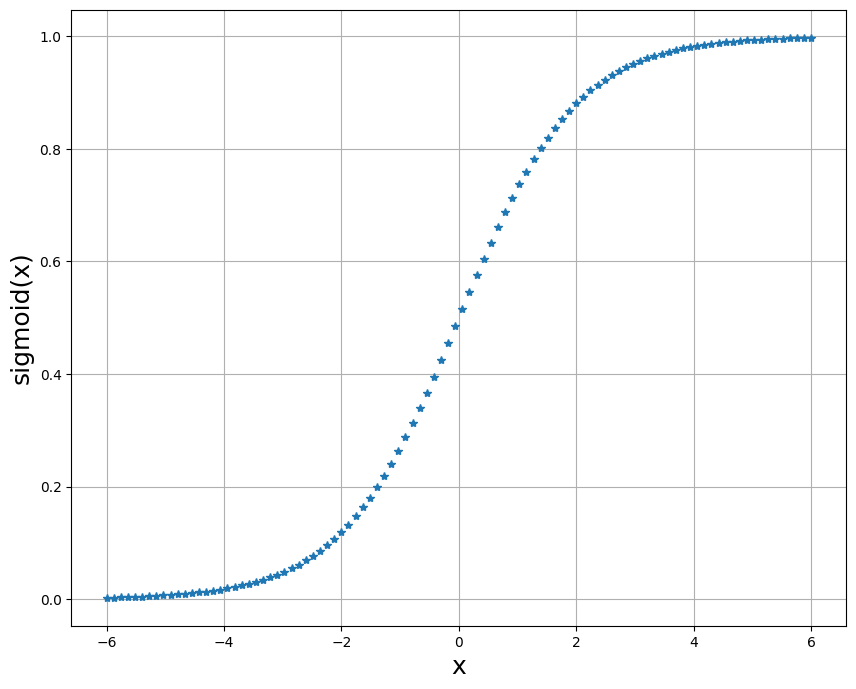

In [ ]:
fig = plt.figure(figsize=(10, 8))

x = np.linspace(-6, 6, 100)
print('x:', x[:5])
y = sigmoid(x)
print('y:', y[:5])
plt.grid()
plt.plot(x, y, '*')

plt.xlabel('x', fontsize=18)
plt.ylabel('sigmoid(x)', fontsize=18)

## Функция потерь

Обучающую выборку можно рассматривать, как реализацию обобщённой схемы Бернулли (реальные ответы 0 или 1) - для каждого объекта генерируется случайная величина, которая с вероятностью p (своей для каждого объекта) принимает значение 1 и с вероятностью (1–p) – 0. Предпологаем, что мы как раз и строим нашу модель так, чтобы она генерировала правильные вероятности, но тогда можно записать функцию правдоподобия:

$$a_{i} = a(x_{i}|w)$$

Это прогноз алгоритма для точки данных $i$ с параметрами $w$.

$$p(y|X, w) = \prod_{i} p(y_{i}|x_{i}w) = \prod_{i} a_{i}^{y_{i}}(1-a_{i})^{(1-y_{i})} \to max$$

Откуда путем логарифмирования правдоподобия получаем, что максимизация функции правдоподобия эквивалентна минимизации:

$$\sum_{i} (-y_{i} log a_{i} - (1 - y_{i})log(1-a_{i}) ) \to min$$

Полученное выражение есть логистическая функция ошибки или кросс-энтропия для одного объекта i.

Кросс энтропия или логистическая функция потерь (logloss):

$$L = \frac{1}{n} \sum_{i} (-y_{i} log a_{i} - (1 - y_{i})log(1-a_{i}) ) \to min$$

В нашей реализации будет использован numpy, операции выше можно будет реализовать через скалярные перемножения векторов:

$$\sum_{i}-y_{i}log(a_{i}) = \vec{y}^{T}\vec{log(a)}$$

Где прогнозы алгоритма $a$ вычисляется по формуле:

$$a=\sigma{(w^{T}X)} = \frac{1}{1+e^{-w^{T}X}}$$


Учтем неприятное свойство логосса: если для объекта 1-го класса мы предсказываем нулевую вероятность принадлежности к этому классу или, наоборот, для объекта 0-го – единичную вероятность принадлежности к классу 1, то ошибка равна бесконечности! Таким образом, грубая ошибка на одном объекте сразу делает алгоритм бесполезным. По этой причине логлосс ограничивают каким-то большим числом (чтобы не связываться с бесконечностями) или добавляют под знак логарифма небольшое значение. В нашем сулчае добавим небольшой $\epsilon = 1*10^{-5}$ (не путать со случайной ошибкой).

In [ ]:
def compute_cost(X, y, w):
    # кол-во элементов в выборке
    n = len(y)
    # прогноз алгоритма для всех точек
    a = sigmoid(X @ w)
    # небольшая константа, чтобы не связываться с бесконечностями в логарифме
    epsilon = 1e-5
    # логистическая функция потерь (см. формулу выше
    cost = (1/n)*(((-y).T @ np.log(a + epsilon))-((1-y).T @ np.log(1-a + epsilon)))
    return cost

## Градиентный спуск

Будем решать логистическую регрессию методом градиентного спуска. Этот метод используется для решения задачи бинарной классификации, который получает вероятность принадлежности к классу 1.

$$L(a, y) = Cross-entropy (a, y) = -ylog(a) - (1-y)log(1-a)$$

Откуда подставив выражение для $a$ (из формул выше):

$$a=\sigma{(w^{T}X)} = \frac{1}{1+e^{-w^{T}X}}$$

Получим правило для обновления параметров алгоритма методом градиентного спуска. Продифференцируем функцию потерть по параметрам:

$$\frac{\partial L}{\partial w} = X(a-y)$$

Тогда один шаг градиентного спуска будет выглядеть:

$$w_{t+1} = w_{t} - \alpha X(a-y)$$

где

* $w$ - веса
* $\alpha$ - скорость обучения (константа равная, например, 0.03)
* $t$ - номер итерации
* $y$ - реальные ответы (целевая)
* $a$ - прогноз алгоритма


In [ ]:
def gradient_descent(X, y, w, learning_rate, iterations):
    # размер выборки
    n = len(y)
    # история потерь по шагам
    cost_history = np.zeros((iterations,1))
    for i in range(iterations):
        # шаг градиентного спуска в логистической регрессии (n для большей численной стабильности)
        w = w - (learning_rate/n) * (X.T @ (sigmoid(X @ w) - y))
        # записываем историю потерь
        cost_history[i] = compute_cost(X, y, w)

    return (cost_history, w)

Когда мы сошлись к оптимальным параметрам можно использовать готовые параметры для предсказания вероятности отношения каждой точки к первому классу:

$$a=\sigma{(w^{T}X)} = \frac{1}{1+e^{-w^{T}X}}$$

In [ ]:
# предсказываем с обученными весами w на заданных значениях X
def predict(X, w):
    return np.round(sigmoid(X @ w))

## Создание синтетических данных

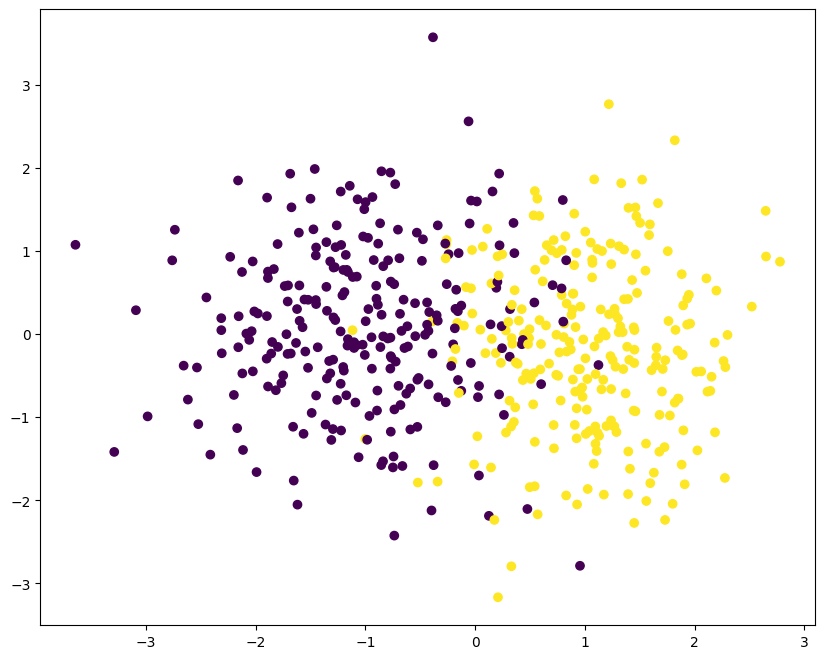

In [ ]:
# Создаем 500 точек для двух классов
X, y = make_classification(n_samples=500, n_features=2, n_redundant=0, n_informative=1,
                             n_clusters_per_class=1, random_state=123)

# для того, чтоб векторно перемножалось корректно
y = y[:,np.newaxis]

# размер фигуры
plt.figure(figsize=(10, 8))
# отображаем
import matplotlib.pyplot as plt

plt.scatter(X[:,0], X[:,1], c=y)
# sns.set_style('white')
# sns.scatterplot(X,hue=y.reshape(-1))

## Инициализация параметров алгоритма

In [ ]:
# размер выборки
n = len(y)
# вектор единиц добавляем в начало выборки для смещения (w_0)
X = np.hstack((np.ones((n,1)), X))

# размер признакового пространства - у нас 3
m = np.size(X,1)

# настраиваемые параметры, зададим нулями
w = np.zeros((m, 1))

print(w.shape)
w

(3, 1)


array([[0.],
       [0.],
       [0.]])

In [ ]:
# смещения, коодината х, координата y
X

array([[ 1.        ,  0.35035256,  1.33745383],
       [ 1.        ,  1.28844157, -1.17893695],
       [ 1.        ,  1.30269273,  0.19021002],
       ...,
       [ 1.        , -1.7346257 ,  0.57779395],
       [ 1.        , -0.59013693, -1.14752541],
       [ 1.        , -0.73623429, -2.42483633]])

In [ ]:
# кол-во итераций обновления
iterations = 1500
# скорость обучения
learning_rate = 0.03

In [ ]:
# проверим, что Loss расчитывается верно
initial_cost = compute_cost(X, y, w)
initial_cost

array([[0.69312718]])

In [ ]:
# проверим, что параметры обновляеются один раз проделав шаг град спуска (см. раздел град спуска)
w - (learning_rate/n) * (X.T @ (sigmoid(X @ w) - y))

array([[ 0.        ],
       [ 0.01531432],
       [-0.00205193]])

## Обучение

In [ ]:
# обучаем с заданными параметрами
cost_history, w = gradient_descent(X, y, w, learning_rate, iterations)

In [ ]:
# найденные оптимальные параметры
w

array([[-0.19475801],
       [ 2.85594761],
       [-0.25263503]])

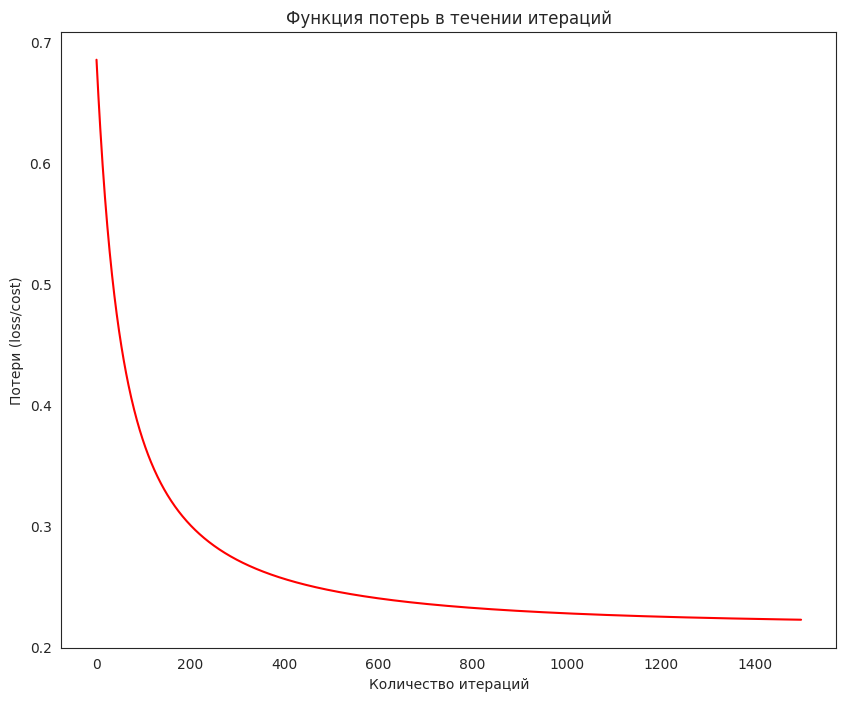

In [ ]:
plt.figure(figsize=(10, 8))
sns.set_style('white')
plt.plot(range(len(cost_history)), cost_history, 'r')
plt.title("Функция потерь в течении итераций")
plt.xlabel("Количество итераций")
plt.ylabel("Потери (loss/cost)")
plt.show()

In [ ]:
# посмотрим на качество на обучающем наборе
y_pred = predict(X, w)
score = float(sum(y_pred == y))/ float(len(y))

print(score)

0.904


<ipython-input-29-c71a526feaf8>:3: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  score = float(sum(y_pred == y))/ float(len(y))


## Визуализируем

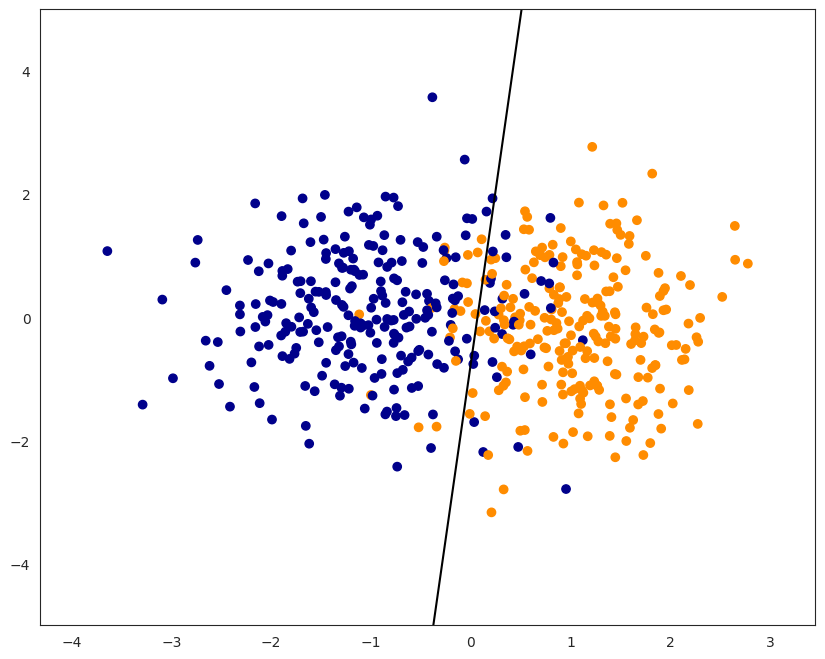

In [ ]:
slope = -(w[1] / w[2])
intercept = -(w[0] / w[2])

plt.figure(figsize=(10, 8))
plt.scatter(X[:,1],X[:,2],c=list(map(lambda x: 'darkblue' if x==0 else 'darkorange', y)))

ax = plt.gca()
x_vals = np.array(ax.get_xlim())
y_vals = intercept + (slope * x_vals)
plt.ylim((-5, 5))
plt.plot(x_vals, y_vals, c="k")